In [9]:
# importing libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

C:\Users\sunid\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# reading the images
for dirname, _, filenames in os.walk('brain_mri_scan_images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

brain_mri_scan_images\negative\0.jpg
brain_mri_scan_images\negative\1.jpg
brain_mri_scan_images\negative\10.jpg
brain_mri_scan_images\negative\11.jpg
brain_mri_scan_images\negative\12.jpg
brain_mri_scan_images\negative\13.jpg
brain_mri_scan_images\negative\14.jpg
brain_mri_scan_images\negative\15.jpg
brain_mri_scan_images\negative\16.jpg
brain_mri_scan_images\negative\17.jpg
brain_mri_scan_images\negative\18.jpg
brain_mri_scan_images\negative\19.jpg
brain_mri_scan_images\negative\2.jpg
brain_mri_scan_images\negative\20.jpg
brain_mri_scan_images\negative\21.jpg
brain_mri_scan_images\negative\22.jpg
brain_mri_scan_images\negative\23.jpg
brain_mri_scan_images\negative\24.jpg
brain_mri_scan_images\negative\25.jpg
brain_mri_scan_images\negative\26.jpg
brain_mri_scan_images\negative\27.jpg
brain_mri_scan_images\negative\28.jpg
brain_mri_scan_images\negative\29.jpg
brain_mri_scan_images\negative\3.jpg
brain_mri_scan_images\negative\30.jpg
brain_mri_scan_images\negative\31.jpg
brain_mri_scan_i

In [3]:
# separating the images as positive and negative class
positive_folder = "brain_mri_scan_images/positive"
negative_folder = "brain_mri_scan_images/negative"

In [4]:
def display_image(folder, label):
    img_name = os.listdir(folder)[0]  # Assuming there's at least one image in each folder
    img_path = os.path.join(folder, img_name)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB for display
    
    plt.imshow(img)
    plt.title(f"{label} Image")
    plt.axis('off')
    plt.show()

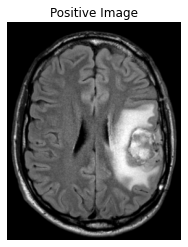

In [5]:
# Load and display a sample positive image
display_image(positive_folder, "Positive")

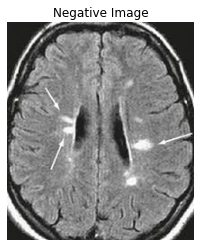

In [6]:
# Load and display a sample negative image
display_image(negative_folder, "Negative")

In [7]:
# Function to pre- process images
def preprocess_images(folder, label, image_size=(224, 224)):
    data = []
    labels = []
    
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize pixel values to the range [0, 1]
        
        data.append(img)
        labels.append(label)
    
    return np.array(data), np.array(labels)

In [8]:
# Preprocess positive images
positive_data, positive_labels = preprocess_images(positive_folder, 1)

# Preprocess negative images
negative_data, negative_labels = preprocess_images(negative_folder, 0)

In [10]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_transfer = Model(inputs=base_model.input, outputs=predictions)
model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [11]:
# Concatenate positive and negative data
X = np.concatenate((positive_data, negative_data), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)

# Shuffling and splitting the data as train set and test set 
shuffle_index = np.random.permutation(len(X))
X_shuffled = X[shuffle_index]
y_shuffled = y[shuffle_index]

split_ratio = 0.8
split_index = int(split_ratio * len(X_shuffled))

X_train, X_test = X_shuffled[:split_index], X_shuffled[split_index:]
y_train, y_test = y_shuffled[:split_index], y_shuffled[split_index:]

# Training the model
model_transfer.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
5/5 [==============================] - 137s 28s/step - loss: 0.6857 - accuracy: 0.5556 - val_loss: 0.6608 - val_accuracy: 0.5676
Epoch 2/5
5/5 [==============================] - 130s 27s/step - loss: 0.6614 - accuracy: 0.5833 - val_loss: 0.6339 - val_accuracy: 0.5676
Epoch 3/5
5/5 [==============================] - 100s 19s/step - loss: 0.6361 - accuracy: 0.5972 - val_loss: 0.6140 - val_accuracy: 0.5676
Epoch 4/5
5/5 [==============================] - 77s 16s/step - loss: 0.6204 - accuracy: 0.5972 - val_loss: 0.5941 - val_accuracy: 0.6486
Epoch 5/5
5/5 [==============================] - 79s 17s/step - loss: 0.6020 - accuracy: 0.6667 - val_loss: 0.5726 - val_accuracy: 0.8108


In [12]:
# Evaluating the model on the test set
test_loss, test_accuracy = model_transfer.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 17s 6s/step - loss: 0.6366 - accuracy: 0.6304
Test Loss: 0.6366229057312012
Test Accuracy: 0.6304348111152649


In [14]:
# Make predictions on the test set
y_pred = model_transfer.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 19s 6s/step
Precision: 0.5853658536585366
Recall: 1.0
F1 Score: 0.7384615384615384
Confusion Matrix:
[[ 5 17]
 [ 0 24]]


The test set accuracy rate for the VGG-16 model is 63%